In [1]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# External classes
from BufferGeometry import BufferGeometry
from GeometryUtils import *
#from utils.analysis import PCA

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import linalg as la
from numpy.linalg import matrix_rank
import seaborn as sns

import torch
import torch.nn.functional as F

In [2]:
"""# Initialize tokenizer and model
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

def get_buffer_states(prompt):
    inputs = tokenizer(prompt, return_tensors="pt")
    input_ids = inputs.input_ids

    with torch.no_grad():
        outputs = model(input_ids, output_hidden_states=True, return_dict=True)
    
    hidden_states = outputs.hidden_states

    # Extract buffer states
    buffer_states = np.array([layer.squeeze(0).numpy() for layer in hidden_states])

    return buffer_states"""

'# Initialize tokenizer and model\ntokenizer = GPT2Tokenizer.from_pretrained("gpt2")\nmodel = GPT2LMHeadModel.from_pretrained("gpt2")\nmodel.eval()\n\ndef get_buffer_states(prompt):\n    inputs = tokenizer(prompt, return_tensors="pt")\n    input_ids = inputs.input_ids\n\n    with torch.no_grad():\n        outputs = model(input_ids, output_hidden_states=True, return_dict=True)\n    \n    hidden_states = outputs.hidden_states\n\n    # Extract buffer states\n    buffer_states = np.array([layer.squeeze(0).numpy() for layer in hidden_states])\n\n    return buffer_states'

In [3]:
"""def general_analysis(filename):
    # Initialize result containers
    volumes = []
    gd = []
    cos_sim = []
    mean_vector = []
    rank_matrix = {}

    # Read prompts from file
    with open(filename, "r") as f:
        prompts = [line.strip() for line in f.readlines() if line.strip()]

    # Loop over the prompts
    for p in prompts:
        # Define matrices to store the results for each prompt
        phrase_volumes = []
        phrase_gd = []
        phrase_cos_sim = []
        phrase_mean_vector = []
        rank_matrix[p] = []
        phrase_rank_matrix = []

        # Get the buffer state 
        buffer_states = get_buffer_states(p)

        # Initial Grassmann reference buffer (from first step)
        buffer_scaled_0 = buffer_states[0,:,:] - np.mean(buffer_states[0,:,:], axis=0, keepdims=True)
        U, S, Vt = la.svd(buffer_scaled_0, lapack_driver='gesvd')
        eigenvalues = S**2
        explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
        n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)+1

        U_reduced = U[:, :n_components]
        S_reduced = np.diag(S[:n_components])
        Vt_reduced = Vt[:n_components, :]
        buffer_reduced_0 = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)

        # Check for NaN or Inf values
        assert not np.isnan(buffer_states).any(), "NaNs detected"
        assert not np.isinf(buffer_states).any(), "Infs detected"

        # Loop over buffer steps
        for i in range(buffer_states.shape[0]):
            bg = BufferGeometry(buffer_states[i, :, :])

            # ===== VOLUME =====
            phrase_volumes.append(bg.volume())

            # ===== COSINE SIMILARITY =====
            phrase_cos_sim.append(bg.cosine_similarity(buffer_states[-1, :, :]))

            # ===== MEAN VECTOR =====
            phrase_mean_vector.append(bg.mean_vector())

            # Reduce current buffer
            buffer_scaled = buffer_states[i,:,:] - np.mean(buffer_states[i,:,:], axis=0, keepdims=True)
            U, S, Vt = la.svd(buffer_scaled, lapack_driver='gesvd')
            eigenvalues = S**2
            explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
            n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)+1

            U_reduced = U[:, :n_components]
            S_reduced = np.diag(S[:n_components])
            Vt_reduced = Vt[:n_components, :]
            buffer_reduced = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)

            # ===== GRASSMANN DISTANCE =====
            bg_reduced = BufferGeometry(buffer_reduced)
            phrase_gd.append(bg_reduced.grassmann_distance(buffer_reduced_0))

            # Update reference buffer
            buffer_reduced_0 = buffer_reduced

            # ===== RANK MATRIX =====
            Q = bg.extract_Q()
            phrase_rank_matrix = np.vstack(Q)


        # Append results for this phrase
        volumes.append(phrase_volumes)
        gd.append(phrase_gd)
        cos_sim.append(phrase_cos_sim)
        mean_vector.append(phrase_mean_vector)
        rank_matrix[p].append(phrase_rank_matrix)
    
    # Count words in each prompt
    word_counts = [len(prompt.split()) for prompt in prompts]

    # Convert to numpy arrays
    volumes = np.array(volumes)
    gd = np.array(gd)
    cos_sim = np.array(cos_sim)
    mean_vector = np.array(mean_vector)

    return volumes, gd, cos_sim, mean_vector, word_counts, rank_matrix"""

'def general_analysis(filename):\n    # Initialize result containers\n    volumes = []\n    gd = []\n    cos_sim = []\n    mean_vector = []\n    rank_matrix = {}\n\n    # Read prompts from file\n    with open(filename, "r") as f:\n        prompts = [line.strip() for line in f.readlines() if line.strip()]\n\n    # Loop over the prompts\n    for p in prompts:\n        # Define matrices to store the results for each prompt\n        phrase_volumes = []\n        phrase_gd = []\n        phrase_cos_sim = []\n        phrase_mean_vector = []\n        rank_matrix[p] = []\n        phrase_rank_matrix = []\n\n        # Get the buffer state \n        buffer_states = get_buffer_states(p)\n\n        # Initial Grassmann reference buffer (from first step)\n        buffer_scaled_0 = buffer_states[0,:,:] - np.mean(buffer_states[0,:,:], axis=0, keepdims=True)\n        U, S, Vt = la.svd(buffer_scaled_0, lapack_driver=\'gesvd\')\n        eigenvalues = S**2\n        explained_variance_ratio = eigenvalues / np

In [4]:
"""def get_heatmap(filename):
    gd_heatmap = []

    # Read prompts from file
    with open(filename, "r") as f:
        prompts = [line.strip() for line in f.readlines() if line.strip()]

    # Loop over the prompts
    for p in prompts:
        # Define matrices to store the results for each prompt
        single_gd_heatmap = np.zeros((13,13))
        # Get the buffer state 
        buffer_states = get_buffer_states(p)

        # Loop over buffer steps
        for i in range(buffer_states.shape[0]):
            # Initial Grassmann reference buffer (from first step)
            buffer_scaled_0 = buffer_states[i,:,:] - np.mean(buffer_states[i,:,:], axis=0, keepdims=True)
            U, S, Vt = la.svd(buffer_scaled_0, lapack_driver="gesvd")
            eigenvalues = S**2
            explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
            n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)+1
            
            #Low rank approximation
            U_reduced = U[:, :n_components]
            S_reduced = np.diag(S[:n_components])
            Vt_reduced = Vt[:n_components, :]
            buffer_reduced_0 = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)
            for j in range(buffer_states.shape[0]):
                bg = BufferGeometry(buffer_states[j, :, :])
                
                # Reduce current buffer
                buffer_scaled = buffer_states[j,:,:] - np.mean(buffer_states[j,:,:], axis=0, keepdims=True)
                U, S, Vt = la.svd(buffer_scaled, lapack_driver="gesvd")
                eigenvalues = S**2
                explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
                n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)+1
                
                # Low rank approximation   
                U_reduced = U[:, :n_components]
                S_reduced = np.diag(S[:n_components])
                Vt_reduced = Vt[:n_components, :]
                buffer_reduced = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)

                # ===== GRASSMANN DISTANCE =====
                bg_reduced = BufferGeometry(buffer_reduced)
                single_gd_heatmap[i,j] = bg_reduced.grassmann_distance(buffer_reduced_0)
        
        # append heatmap matrix for that prompt
        gd_heatmap.append(single_gd_heatmap)

    return np.array(gd_heatmap)"""

'def get_heatmap(filename):\n    gd_heatmap = []\n\n    # Read prompts from file\n    with open(filename, "r") as f:\n        prompts = [line.strip() for line in f.readlines() if line.strip()]\n\n    # Loop over the prompts\n    for p in prompts:\n        # Define matrices to store the results for each prompt\n        single_gd_heatmap = np.zeros((13,13))\n        # Get the buffer state \n        buffer_states = get_buffer_states(p)\n\n        # Loop over buffer steps\n        for i in range(buffer_states.shape[0]):\n            # Initial Grassmann reference buffer (from first step)\n            buffer_scaled_0 = buffer_states[i,:,:] - np.mean(buffer_states[i,:,:], axis=0, keepdims=True)\n            U, S, Vt = la.svd(buffer_scaled_0, lapack_driver="gesvd")\n            eigenvalues = S**2\n            explained_variance_ratio = eigenvalues / np.sum(eigenvalues)\n            n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)+1\n            \n            #Low rank appro

In [5]:
"""# Plotting functions
def plot_geometry(array, word_counts, title, xlabel, ylabel):
    colormap_name="YlOrRd"
    cmap = plt.colormaps[colormap_name]
    color_positions = np.linspace(0.2, 1, 10)
    colors = [cmap(pos) for pos in color_positions]
    markers = ["^", "o", "s", "X", "v", ">", "<", "P", "D", "*"]
    linestyles = ["solid", "dotted", "dashed", "dashdot", "dashed"]*2


    plt.figure()
    for i in range(array.shape[0]):
        color = colors[i]
        marker = markers[i]
        linestyle = linestyles[i]
        
        plt.plot(range(array.shape[1]), array[i], color=color, marker=marker, linestyle=linestyle, label=f"{word_counts[i]}")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.6)
    plt.legend(loc="best", title="Number of tokens", ncol=3)
    plt.tight_layout()
    plt.show()
"""

'# Plotting functions\ndef plot_geometry(array, word_counts, title, xlabel, ylabel):\n    colormap_name="YlOrRd"\n    cmap = plt.colormaps[colormap_name]\n    color_positions = np.linspace(0.2, 1, 10)\n    colors = [cmap(pos) for pos in color_positions]\n    markers = ["^", "o", "s", "X", "v", ">", "<", "P", "D", "*"]\n    linestyles = ["solid", "dotted", "dashed", "dashdot", "dashed"]*2\n\n\n    plt.figure()\n    for i in range(array.shape[0]):\n        color = colors[i]\n        marker = markers[i]\n        linestyle = linestyles[i]\n        \n        plt.plot(range(array.shape[1]), array[i], color=color, marker=marker, linestyle=linestyle, label=f"{word_counts[i]}")\n    plt.title(title)\n    plt.xlabel(xlabel)\n    plt.ylabel(ylabel)\n    plt.grid(alpha=0.6)\n    plt.legend(loc="best", title="Number of tokens", ncol=3)\n    plt.tight_layout()\n    plt.show()\n'

In [6]:
# Test
volumes, gd, cos_sim, mean_vector, word_counts, rank_matrix = general_analysis("prompts.txt")
gd_heatmap = get_heatmap("prompts.txt")

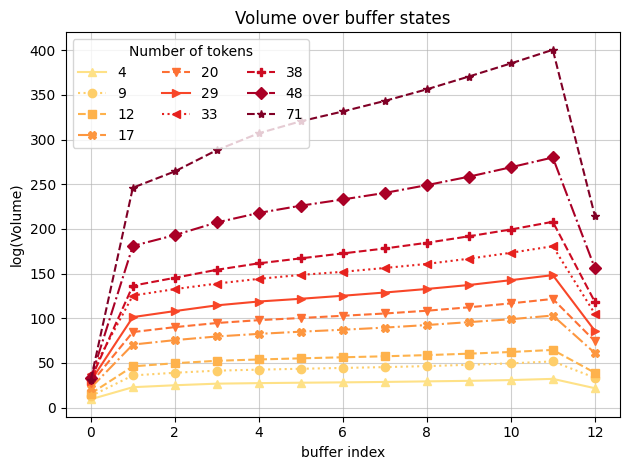

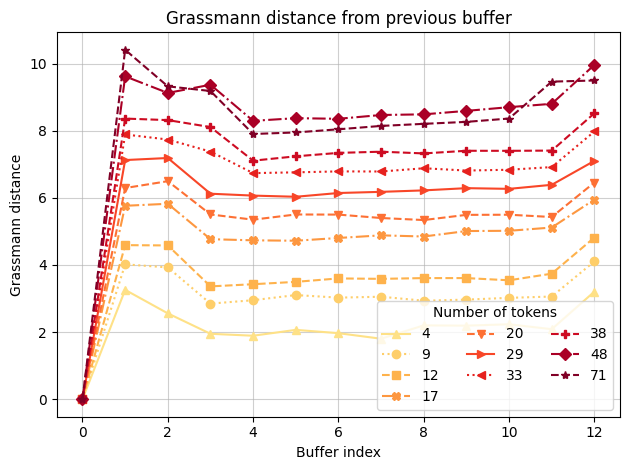

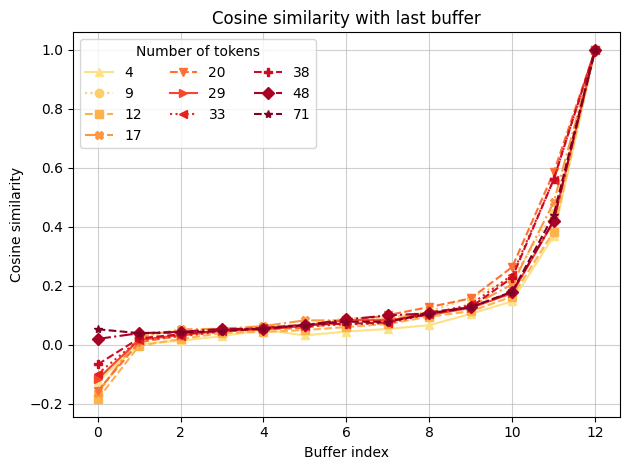

In [7]:
# Plot testing
plot_geometry(volumes, word_counts, title="Volume over buffer states", xlabel="buffer index", ylabel="log(Volume)")
plot_geometry(gd, word_counts, title="Grassmann distance from previous buffer", xlabel="Buffer index", ylabel="Grassmann distance")
plot_geometry(cos_sim, word_counts, title="Cosine similarity with last buffer", xlabel="Buffer index", ylabel="Cosine similarity")

In [8]:
"""# --- Cosine Similarity Plot ---

colormap_name="YlOrRd"
cmap = plt.colormaps[colormap_name]
color_positions = np.linspace(0.2, 1, 10)
colors = [cmap(pos) for pos in color_positions]
markers = ["^", "o", "s", "X", "v", ">", "<", "P", "D", "*"]
linestyles = ["solid", "dotted", "dashed", "dashdot", "dashed"]*2


plt.figure()
for i in range(cos_sim.shape[0]):
    color = colors[i]
    marker = markers[i]
    linestyle = linestyles[i]
    
    plt.plot(range(cos_sim.shape[1]), cos_sim[i], color=color, marker=marker, linestyle=linestyle, label=f"{word_counts[i]}")
plt.title("Cosine similarity with last buffer state")
plt.xlabel("Buffer index")
plt.ylabel("Cosine similarity")
plt.grid(alpha=0.6)
plt.legend(loc="best", title="Number of tokens", ncol=3)
plt.tight_layout()
plt.show()"""

'# --- Cosine Similarity Plot ---\n\ncolormap_name="YlOrRd"\ncmap = plt.colormaps[colormap_name]\ncolor_positions = np.linspace(0.2, 1, 10)\ncolors = [cmap(pos) for pos in color_positions]\nmarkers = ["^", "o", "s", "X", "v", ">", "<", "P", "D", "*"]\nlinestyles = ["solid", "dotted", "dashed", "dashdot", "dashed"]*2\n\n\nplt.figure()\nfor i in range(cos_sim.shape[0]):\n    color = colors[i]\n    marker = markers[i]\n    linestyle = linestyles[i]\n    \n    plt.plot(range(cos_sim.shape[1]), cos_sim[i], color=color, marker=marker, linestyle=linestyle, label=f"{word_counts[i]}")\nplt.title("Cosine similarity with last buffer state")\nplt.xlabel("Buffer index")\nplt.ylabel("Cosine similarity")\nplt.grid(alpha=0.6)\nplt.legend(loc="best", title="Number of tokens", ncol=3)\nplt.tight_layout()\nplt.show()'

In [9]:
"""# --- Volume Plot ---
plt.figure()
for i in range(volumes.shape[0]):
    volumes.shape[1]
    color = colors[i]
    marker = markers[i]
    linestyle = linestyles[i]

    plt.plot(range(volumes.shape[1]), volumes[i], color=color, marker=marker, label=f"{word_counts[i]}")
    
plt.title("Volume over buffer state")
plt.xlabel("Buffer index")
plt.ylabel("log(Volume)")
#plt.yscale("log")
plt.grid(alpha=0.6)
plt.legend(loc="best", title="Number of tokens", ncol=3)
plt.tight_layout()
plt.show()"""

'# --- Volume Plot ---\nplt.figure()\nfor i in range(volumes.shape[0]):\n    volumes.shape[1]\n    color = colors[i]\n    marker = markers[i]\n    linestyle = linestyles[i]\n\n    plt.plot(range(volumes.shape[1]), volumes[i], color=color, marker=marker, label=f"{word_counts[i]}")\n    \nplt.title("Volume over buffer state")\nplt.xlabel("Buffer index")\nplt.ylabel("log(Volume)")\n#plt.yscale("log")\nplt.grid(alpha=0.6)\nplt.legend(loc="best", title="Number of tokens", ncol=3)\nplt.tight_layout()\nplt.show()'

In [10]:
"""# --- Grassmann Distance Plot ---
plt.figure()
for i in range(gd.shape[0]):
    color = colors[i]
    marker = markers[i]
    linestyle = linestyles[i]

    plt.plot(range(gd.shape[1]), gd[i], color=color, marker=marker, label=f"{word_counts[i]}")
    
plt.title("Grassmann distance to previous buffer")
plt.xlabel("Buffer index")
plt.ylabel("Grassmann distance")
plt.grid(alpha=0.6)
plt.legend(loc="best", title="Number of tokens", ncol=3)
plt.tight_layout()
plt.show()"""

'# --- Grassmann Distance Plot ---\nplt.figure()\nfor i in range(gd.shape[0]):\n    color = colors[i]\n    marker = markers[i]\n    linestyle = linestyles[i]\n\n    plt.plot(range(gd.shape[1]), gd[i], color=color, marker=marker, label=f"{word_counts[i]}")\n    \nplt.title("Grassmann distance to previous buffer")\nplt.xlabel("Buffer index")\nplt.ylabel("Grassmann distance")\nplt.grid(alpha=0.6)\nplt.legend(loc="best", title="Number of tokens", ncol=3)\nplt.tight_layout()\nplt.show()'

In [11]:
np.shape(mean_vector)

(10, 13, 768)

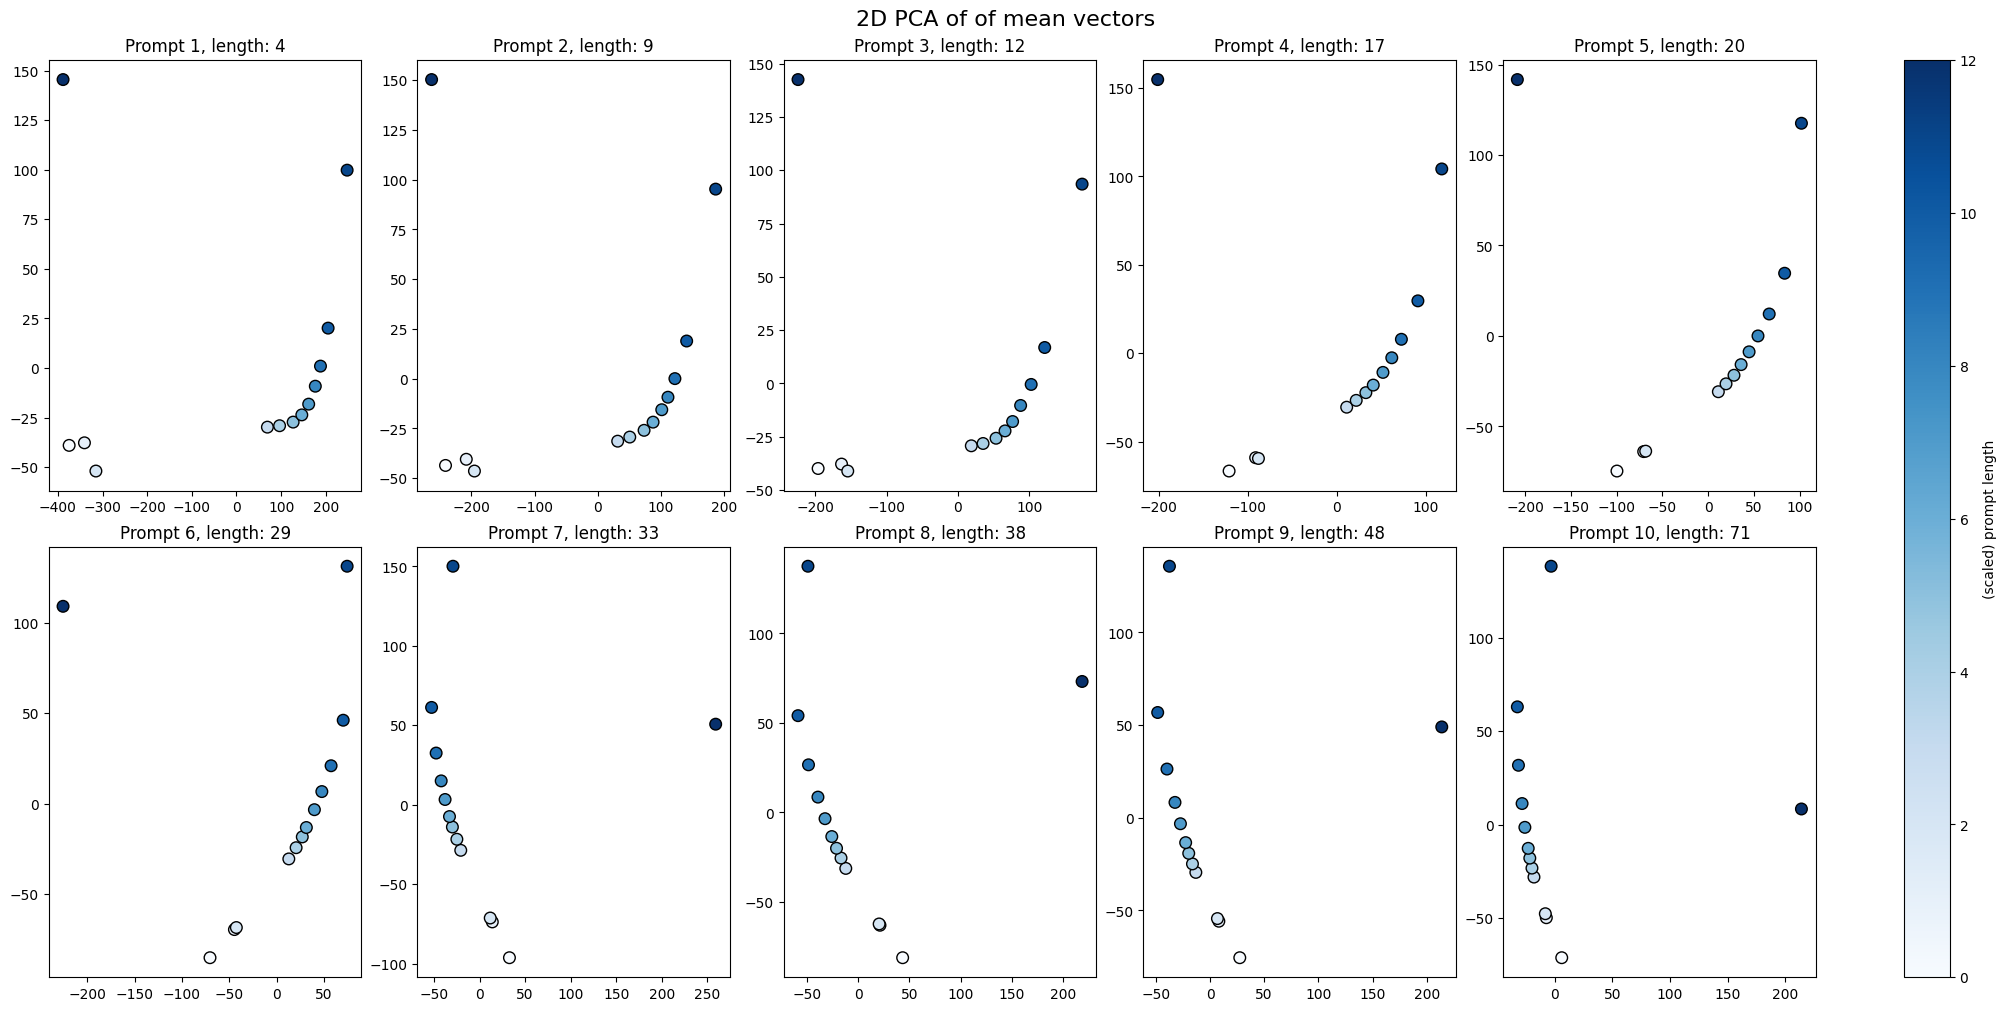

In [12]:
# Create subplots
fig, axs = plt.subplots(2, 5, figsize=(20, 10), constrained_layout=True)
axs = axs.flatten()

num_points = mean_vector.shape[1]
colors = np.arange(num_points)

for i in range(10):
    fixed_mean_vector = mean_vector[i, :, :]
    
    pca = PCA(n_components=2)
    proj = pca.fit_transform(fixed_mean_vector)
    
    scatter = axs[i].scatter(proj[:, 0], proj[:, 1], c=colors, cmap="Blues", s=70, edgecolor="black")
    axs[i].set_title(f"Prompt {i+1}, length: {word_counts[i]}")

# Shared colorbar
cbar = fig.colorbar(scatter, ax=axs, label="(scaled) prompt length")
fig.suptitle("2D PCA of of mean vectors", fontsize=16)
plt.show()

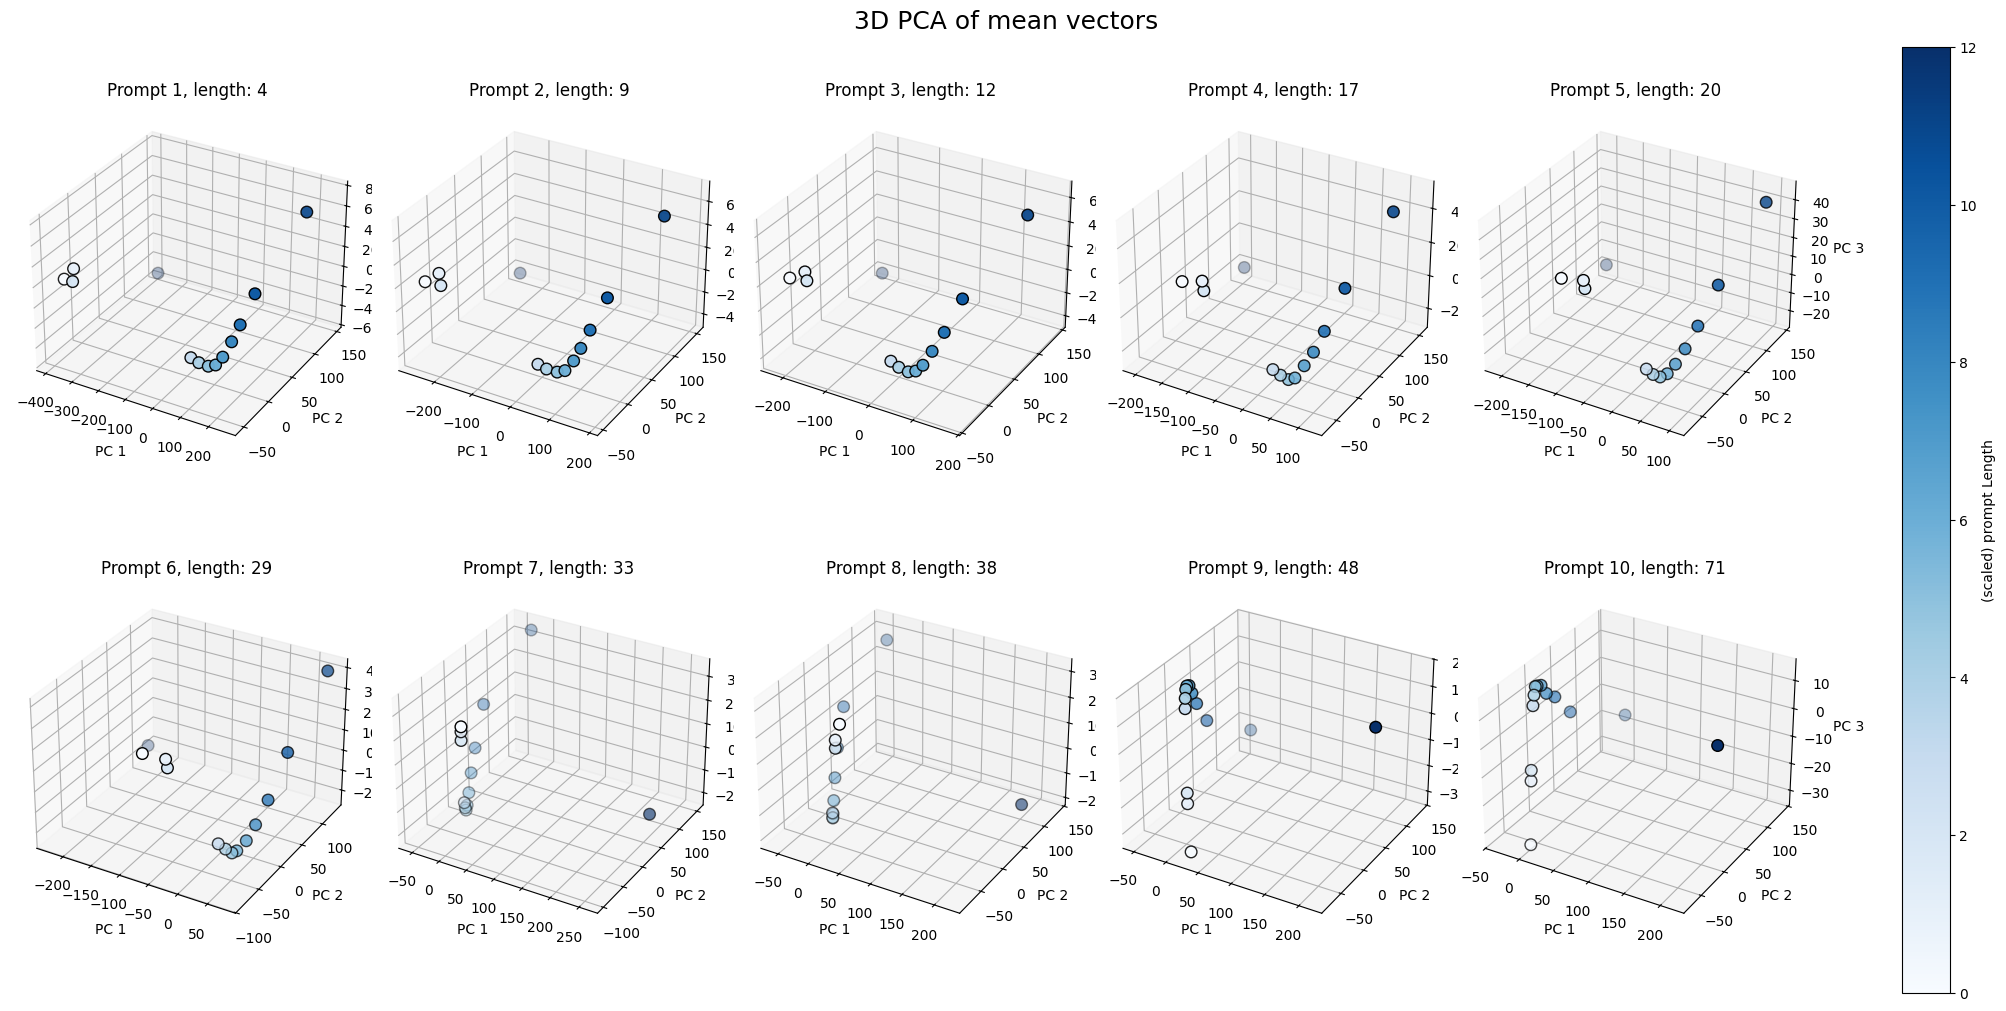

In [13]:
# Create subplots 
fig = plt.figure(figsize=(20, 10), constrained_layout=True)
axs = [fig.add_subplot(2, 5, i+1, projection='3d') for i in range(10)]

num_points = mean_vector.shape[1]
colors = np.arange(num_points)

for i in range(10):
    fixed_mean_vector = mean_vector[i, :, :]
    
    pca = PCA(n_components=3)
    proj = pca.fit_transform(fixed_mean_vector)
    
    scatter = axs[i].scatter(proj[:, 0], proj[:, 1], proj[:, 2], c=colors, cmap="Blues", s=70, edgecolor="black")
    axs[i].set_title(f"Prompt {i+1}, length: {word_counts[i]}")
    axs[i].set_xlabel("PC 1")
    axs[i].set_ylabel("PC 2")
    axs[i].set_zlabel("PC 3")

# Shared colorbar
fig.colorbar(scatter, ax=axs, label="(scaled) prompt Length", orientation='vertical')
fig.suptitle("3D PCA of mean vectors", fontsize=18)
plt.show()

In [14]:
ranks = []
for prompt, matrices in rank_matrix.items():
    for i, mat in enumerate(matrices):
        rank = matrix_rank(mat)
        ranks.append(rank/768)

print(np.round(ranks, 3)*100)

[ 0.8  1.3  1.7  2.7  3.3  4.   4.9  5.7  7.8 11.5]


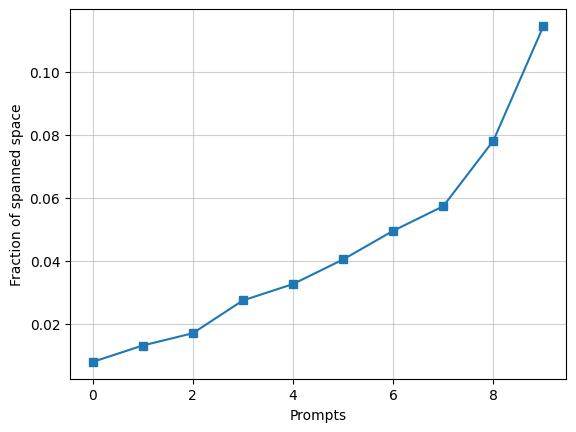

In [15]:
plt.plot(np.arange(len(ranks)), ranks, marker='s')
plt.xlabel("Prompts")
plt.ylabel("Fraction of spanned space")

plt.grid(alpha=0.6)
plt.show()

(10, 13, 13)


/var/folders/9p/sxfs2z3j2ln1p3kz5qdq03_w0000gn/T/ipykernel_84461/2642595489.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


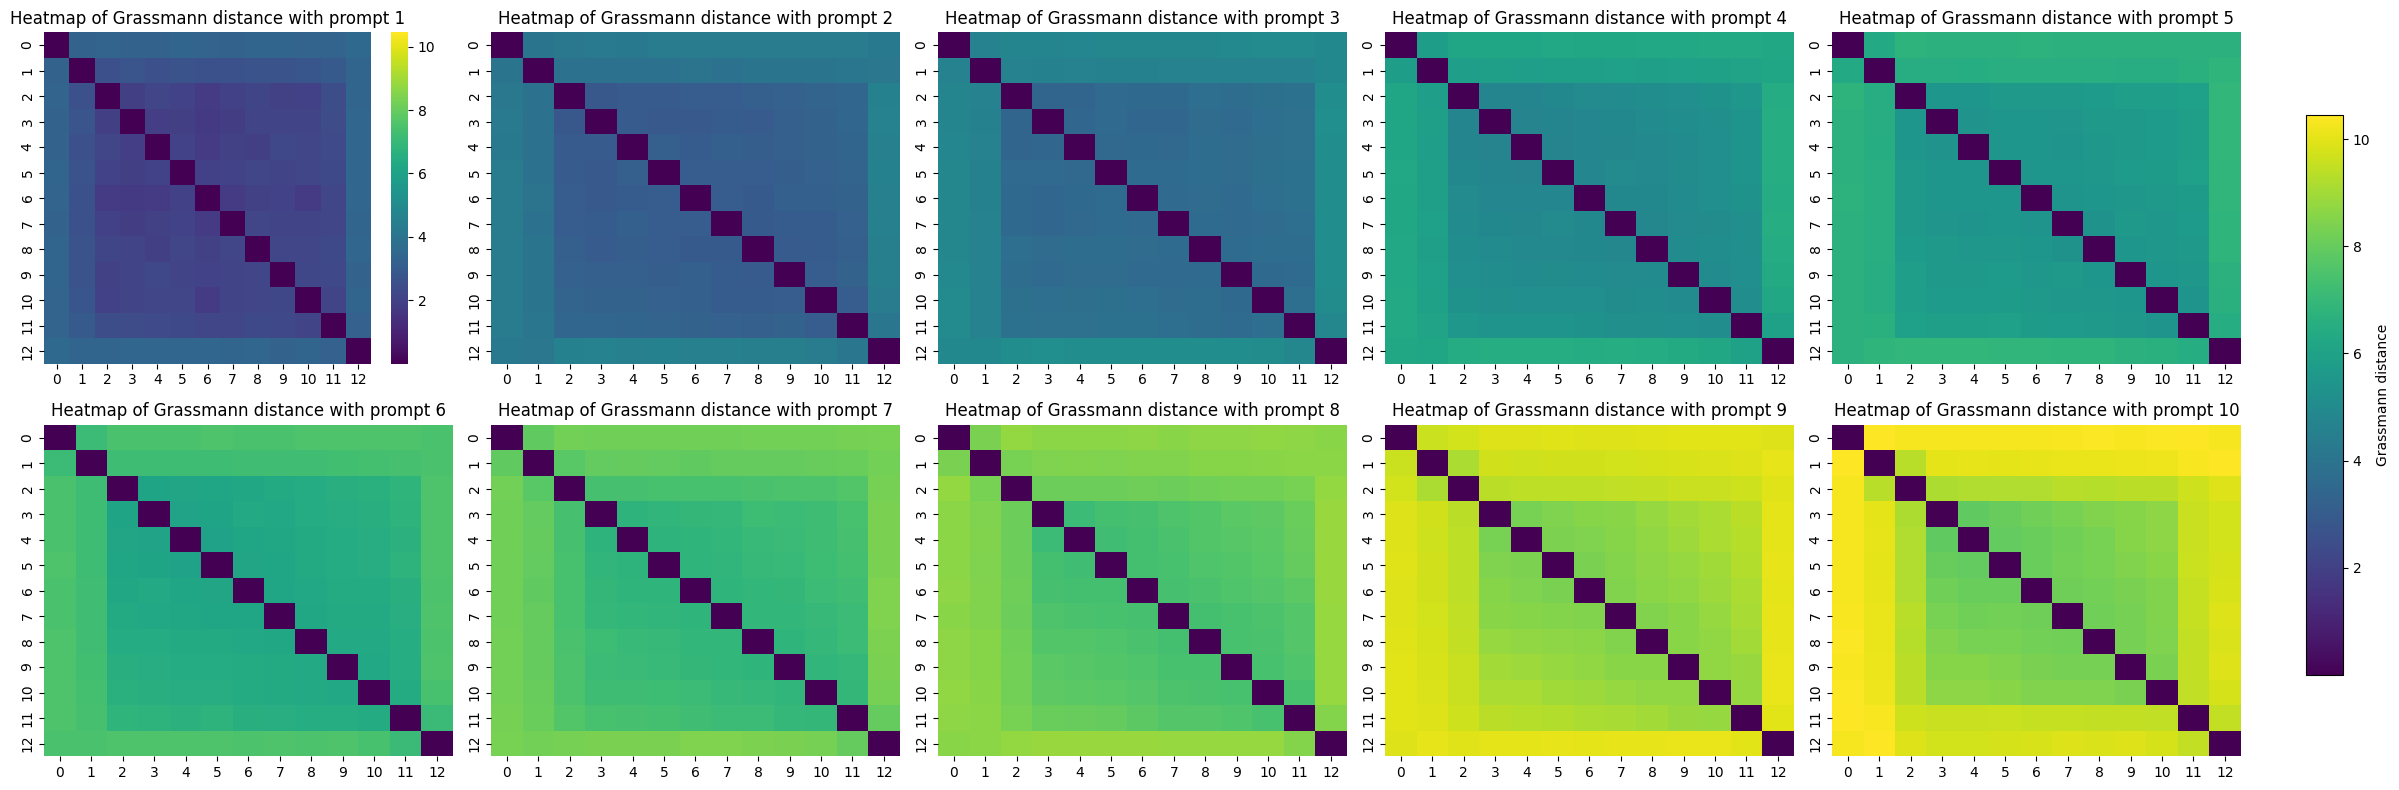

In [16]:
# Find global min and max across all heatmaps
vmin = np.min(gd_heatmap)
vmax = np.max(gd_heatmap)

print(np.shape(gd_heatmap))

fig, axes = plt.subplots(2, 5, figsize=(25, 8))
axes = axes.flatten()

# Create a dummy heatmap to get the mappable for colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]

for i in range(gd_heatmap.shape[0]):
    ax = axes[i]
    hm = sns.heatmap(
        gd_heatmap[i],
        ax=ax,
        cmap='viridis',
        vmin=vmin,
        vmax=vmax,
        cbar=(i==0),  
        cbar_ax=None   
    )
    ax.set_title(f"Heatmap of Grassmann distance with prompt {i + 1}")

# Create a single colorbar for all subplots
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([]) 
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label("Grassmann distance")

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

In [17]:
# Read prompts from file
with open("prompts_768.txt", "r") as f:
    prompts = [line.strip() for line in f.readlines() if line.strip()]

gd_heatmap = []
# Loop over the prompts
for p in prompts:
    # Define matrices to store the results for each prompt
    single_gd_heatmap = np.zeros((13,13))
    # Get the buffer state 
    buffer_states = get_buffer_states(p)

    # Loop over buffer steps
    for i in range(buffer_states.shape[0]):
        # Initial Grassmann reference buffer (from first step)
        buffer_scaled_0 = buffer_states[i,:,:] - np.mean(buffer_states[i,:,:], axis=0, keepdims=True)
        U, S, Vt = la.svd(buffer_scaled_0, lapack_driver='gesvd')
        eigenvalues = S**2
        explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
        n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)+1
        
        #Low rank approximation
        U_reduced = U[:, :n_components]
        S_reduced = np.diag(S[:n_components])
        Vt_reduced = Vt[:n_components, :]
        buffer_reduced_0 = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)
        for j in range(buffer_states.shape[0]):
            bg = BufferGeometry(buffer_states[j, :, :])
            
            # Reduce current buffer
            buffer_scaled = buffer_states[j,:,:] - np.mean(buffer_states[j,:,:], axis=0, keepdims=True)
            U, S, Vt = la.svd(buffer_scaled, lapack_driver='gesvd')
            eigenvalues = S**2
            explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
            n_components = np.argmax(np.cumsum(explained_variance_ratio) >= 0.9)+1
            
            # Low rank approximation   
            U_reduced = U[:, :n_components]
            S_reduced = np.diag(S[:n_components])
            Vt_reduced = Vt[:n_components, :]
            buffer_reduced = np.dot(np.dot(U_reduced, S_reduced), Vt_reduced)

            # ===== GRASSMANN DISTANCE =====
            bg_reduced = BufferGeometry(buffer_reduced)
            single_gd_heatmap[i,j] = bg_reduced.grassmann_distance(buffer_reduced_0)
    
    # append heatmap matrix for that prompt
    gd_heatmap.append(single_gd_heatmap)


gd_heatmap = np.array(gd_heatmap)

with open("prompts_768.txt", "r") as f:
    prompts = [line.strip() for line in f.readlines() if line.strip()]


token_counts = [len(tokenizer.tokenize(p)) for p in prompts]

print(token_counts)

gd_avg = np.mean(gd_heatmap, axis=(1,2))

plt.figure(figsize=(8,5))
plt.plot(token_counts, gd_avg, marker='o', linestyle='-', color='purple', linewidth=2, markersize=5, label = 'Average Grassmann Distance')
plt.title('Average Grassmann Distance vs Number of Tokens', fontsize=14, fontweight='bold')
plt.xlabel('Number of Tokens', fontsize=12)
plt.ylabel('Average Grassmann Distance', fontsize=12)
plt.grid(alpha=0.3)

# Vertical line at 768
plt.vlines(ymax = np.max(gd_avg), ymin = np.min(gd_avg), x = 768, linestyle = 'dashed', color = 'red', label = 'Embedding dimension (768)')

# Shaded regions
plt.axvspan(min(token_counts), 768, color='lightblue', alpha=0.3, label='Complex dynamics')
plt.axvspan(768, max(token_counts), color='lightgreen', alpha=0.3, label='Rigid translation')

plt.legend()
plt.tight_layout()
plt.show()